<a href="https://colab.research.google.com/github/Aravindan98/DeepGalerkin-FourierNeural/blob/main/DGM_Peral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\nabla ^2 f(x,y,z)=sin(x^2+y^2+z^2)$

$f(x,y,z)=0 $ @  $x^2+y^2+z^2=1$

Installing required dependencies. Note: TensorFlow version is 1

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel

#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,x,y,z):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([x,y,z],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

def Sampler(n_interior, n_boundary):

    U = (np.random.uniform(low=0, high=1, size=[n_interior,1]))**(1/3)
    
    x_interior = np.random.randn(n_interior,1)
    y_interior = np.random.randn(n_interior,1)
    z_interior = np.random.randn(n_interior,1)
    
    mag = np.sqrt(x_interior**2+y_interior**2+z_interior**2)    
    
    x_interior = U*x_interior/mag
    y_interior = U*y_interior/mag
    z_interior = U*z_interior/mag
    
    s_interior=[x_interior, y_interior, z_interior]

    x_boundary = np.random.randn(n_boundary,1)
    y_boundary = np.random.randn(n_boundary,1)
    z_boundary = np.random.randn(n_boundary,1)

    mag = np.sqrt(x_boundary**2 + y_boundary**2 + z_boundary**2)  
    
    x_boundary = x_boundary/mag
    y_boundary = y_boundary/mag
    z_boundary = z_boundary/mag      

    s_boundary=[x_boundary, y_boundary, z_boundary]

    return s_interior, s_boundary

def loss(model, x_interior_tnsr, y_interior_tnsr, z_interior_tnsr, x_boundary_tnsr, y_boundary_tnsr, z_boundary_tnsr):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        {x/y/z}_interior_tnsr:  tensors on the axis for the interior 
        {x/y/z}_boundary_tnsr: tensors on the axis for the boundary
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    k = 1e-6
    U = tf.math.log(model(x_interior_tnsr, y_interior_tnsr, z_interior_tnsr))
    U_x = tf.math.divide(tf.gradients(U, x_interior_tnsr)[0] ,tf.math.exp(U)+k)
    U_xx = tf.math.divide(tf.gradients(U_x, x_interior_tnsr)[0] - tf.math.exp(U)*U_x**2 , tf.math.exp(U)+k)
    U_y = tf.math.divide(tf.gradients(U, y_interior_tnsr)[0] ,tf.math.exp(U)+k)
    U_yy = tf.math.divide(tf.gradients(U_y, y_interior_tnsr)[0] - tf.math.exp(U)*U_y**2 , tf.math.exp(U)+k)
    U_z = tf.math.divide(tf.gradients(U, z_interior_tnsr)[0] ,tf.math.exp(U)+k)
    U_zz = tf.math.divide(tf.gradients(U_z, z_interior_tnsr)[0] - tf.math.exp(U)*U_z**2 , tf.math.exp(U)+k)
    diff_U = tf.math.exp(U)*U_x**2+tf.math.exp(U)*U_xx + tf.math.exp(U)*U_y**2+tf.math.exp(U)*U_yy +tf.math.exp(U)*U_z**2+tf.math.exp(U)*U_zz+ (tf.abs(tf.math.exp(U))**4)*tf.math.exp(U) + (tf.abs(tf.math.exp(U))**3)*tf.math.exp(U)

    L1 = tf.reduce_mean(tf.square(diff_U),0) 
    
    Ub = tf.math.log(model(x_boundary_tnsr, y_boundary_tnsr, z_boundary_tnsr))
    L2 = tf.reduce_mean(tf.square(Ub),0)

    '''
    add 1/u to penalize.
    '''
    #L3 = tf.reduce_mean(tf.square(1/U),0)
    '''
    No Loss condition wrt to initial condition
    '''
    t = tf.concat([tf.math.exp(U)*U_x,tf.math.exp(U)*U_y,tf.math.exp(U)*U_z],0)
    L4 = (tf.reduce_sum(tf.norm(t,2)**2))/2
    L5 = -(tf.reduce_sum(tf.abs(tf.math.exp(U))**5))/5
    L6 = -(tf.reduce_sum(tf.abs(tf.math.exp(U))**6))/6
    return L4, L5, L6

def train(epochs,n_interior,n_boundary):
    for i in range(epochs):
    
        # sample uniformly from the required regions
        interior_points, boundary_points = Sampler(n_interior, n_boundary)
    
        # for a given sample, take the required number of SGD steps
        for _ in range(steps_per_sample):
            loss,L1,L2,L3,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr,L3_tnsr, optimizer],
                                    feed_dict = {x_interior_tnsr:interior_points[0], y_interior_tnsr:interior_points[1], z_interior_tnsr:interior_points[2], x_boundary_tnsr:boundary_points[0], y_boundary_tnsr:boundary_points[1], z_boundary_tnsr:boundary_points[2]})
    
        print(f"Epoch {i}: Loss={loss} Loss_Interior={L1} Loss_Boundary={L2} Loss_penalty={L3}".format(i,float(loss),float(L1),float(L2),float(L3)))

    return loss    

def trueSolution(input):
    x,y,z = input
    sq = np.sqrt(x**2 + y**2 + z**2)
    const = np.sqrt(2/np.pi)
    ans = (1/(2*const))*(fresnel(const)[1] - fresnel(const*sq)[1]/sq)
    return ans     

def plot_true_vs_approx(DGM_soln,true_soln):
    plt.style.use(['ggplot'])
    plt.figure(figsize=(10,7))
    plt.plot(x,DGM_soln,label="DGM")
    plt.plot(x,true_soln,label="True")
    plt.xlabel("X-Coordinate")
    plt.ylabel("Solution")
    plt.legend()


TensorFlow 1.x selected.
1.15.2


In [ ]:

# Solution = sess.run([V], feed_dict= {x_interior_tnsr:x, y_interior_tnsr:y, z_interior_tnsr:z})
# Solution = np.array(Solution[0])



$p=2$ || $N=3$ || $q=5$ || $p^{*}=6$ || $\lambda=1$

Creating the computation graph in TensorFlow

In [ ]:
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 100   # number of times to resample new time-space domain points
steps_per_sample = 15    # number of SGD steps to take before re-sampling

# Sampling parameters
n_interior = 10000
n_boundary = 10000
# S_multiplier  = 1.5 


model = DGMNet(nodes_per_layer, num_layers, 3)

x_interior_tnsr = tf.placeholder(tf.float32, [None,1])
y_interior_tnsr = tf.placeholder(tf.float32, [None,1])
z_interior_tnsr = tf.placeholder(tf.float32, [None,1])
x_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
y_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
z_boundary_tnsr = tf.placeholder(tf.float32, [None,1])


L1_tnsr, L2_tnsr, L3_tnsr = loss(model, x_interior_tnsr, y_interior_tnsr, z_interior_tnsr, x_boundary_tnsr, y_boundary_tnsr, z_boundary_tnsr)

loss_tnsr = tf.abs(L1_tnsr + L2_tnsr + L3_tnsr)

V = model(x_interior_tnsr, y_interior_tnsr, z_interior_tnsr)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
from numpy import linalg as LA
def conv_error(true_soln, approx_soln):
    return LA.norm(true_soln-approx_soln)

1) Save the model weights

2) save the session(computation graph)

**SAVE IN NSDE_deep**

$Laplace(x,y,z)=|u|^4u+|u|^3u$

In [ ]:
#saver = tf.train.Saver(max_to_keep=1) 
sess=tf.Session()
sess.run(init_op)
loss=train(100,10,10)
#savePath = saver.save(sess, './my_model.ckpt')


Epoch 0: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 1: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 2: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 3: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 4: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 5: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 6: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 7: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 8: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 9: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 10: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 11: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 12: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Epoch 13: Loss=nan Loss_Interior=nan Loss_Boundary=nan Loss_penalty=nan
Ep

KeyboardInterrupt: ignored

The following cell must be executed to plot the solution

AttributeError: ignored

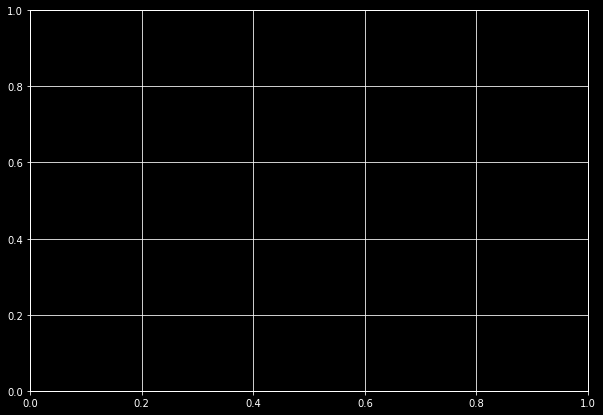

In [ ]:
import matplotlib.pyplot as plt
import math
x=np.reshape(np.linspace(-1,1),(-1,1))
y=np.zeros_like(x)
z=np.zeros_like(x)

Solution = sess.run([V], feed_dict= {x_interior_tnsr:x, y_interior_tnsr:y, z_interior_tnsr:z})
Solution = np.array(Solution[0])
plt.style.use(['ggplot'])
plt.style.use(['dark_background'])
plt.figure(figsize=(10,7))
plt.plot(x,np.exp(Solution))
plt.xlabel("x-coordinate")
plt.ylabel("Solution")

1) plot U vs x,y,z



How important is sampling?

How actual results differs numerical results?

Look for convergence and possibly its order

In [ ]:
plot(Sol,ts)

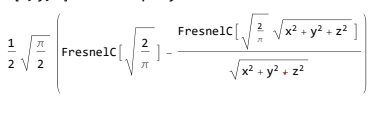